# Mel Spectrograms & Filter Banks: Complete Visual Guide

## Introduction

This notebook provides a **comprehensive deep dive** into:

1. **Why Mel Scale?** - The problem with linear frequency
2. **Mel Scale Mathematics** - Formulas and intuition
3. **Mel Filter Banks** - Step-by-step construction
4. **Mel Spectrograms** - From standard to perceptual
5. **Practical Implementation** - Real code and examples

Everything explained with **extensive visualizations** and **hands-on examples**.

---

## Prerequisites

Before starting this notebook, you should understand:
- ✅ Sampling rate (sr)
- ✅ FFT size (n_fft)
- ✅ Hop length
- ✅ Frequency bins
- ✅ Standard spectrograms

*(See Notebook 11: FFT Parameters Explained)*

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


---

# Part 1: The Problem with Linear Frequency

## Why Standard Spectrograms Aren't Enough

Standard spectrograms use a **linear frequency scale**:
- The distance between 100 Hz and 200 Hz is the same as between 1000 Hz and 1100 Hz
- Both are 100 Hz apart

**But humans don't hear this way!**

### Human Hearing is Logarithmic

**Example:**
- 100 Hz → 200 Hz: Sounds like a **HUGE** pitch change (one octave)
- 1000 Hz → 1100 Hz: Sounds like a **SMALL** pitch change

Both are 100 Hz differences, but we perceive them very differently!

### The Musical Perspective

On a piano:
- Each octave **doubles** the frequency
- A4 (440 Hz) → A5 (880 Hz) = one octave
- A5 (880 Hz) → A6 (1760 Hz) = one octave

Equal **perceptual** distances require **exponentially increasing** Hz differences!

In [2]:
# Demonstrate the perceptual difference
import pandas as pd

# Compare frequency pairs with same Hz difference
comparisons = [
    (100, 200, "Low frequency"),
    (500, 600, "Mid-low frequency"),
    (1000, 1100, "Mid frequency"),
    (5000, 5100, "High frequency"),
    (10000, 10100, "Very high frequency")
]

data = []
for f1, f2, desc in comparisons:
    hz_diff = f2 - f1
    ratio = f2 / f1
    cents = 1200 * np.log2(ratio)  # Musical cents
    
    data.append({
        'Description': desc,
        'Frequency Range': f"{f1}-{f2} Hz",
        'Hz Difference': f"{hz_diff} Hz",
        'Frequency Ratio': f"{ratio:.3f}",
        'Perceived Change (cents)': f"{cents:.1f}",
        'Perceptual Impact': 'HUGE' if cents > 150 else 'Large' if cents > 50 else 'Medium' if cents > 20 else 'Small'
    })

df = pd.DataFrame(data)
print("\n" + "="*100)
print("PERCEPTUAL COMPARISON: Same Hz Difference (100 Hz), Different Perception")
print("="*100)
print(df.to_string(index=False))
print("="*100)
print("\n💡 Key Insight:")
print("   Even though all pairs have the SAME 100 Hz difference,")
print("   the PERCEIVED pitch change decreases dramatically at higher frequencies!")
print("\n   100→200 Hz: 1200 cents (one full octave!)")
print("   10000→10100 Hz: Only 17 cents (barely noticeable)")


PERCEPTUAL COMPARISON: Same Hz Difference (100 Hz), Different Perception
        Description Frequency Range Hz Difference Frequency Ratio Perceived Change (cents) Perceptual Impact
      Low frequency      100-200 Hz        100 Hz           2.000                   1200.0              HUGE
  Mid-low frequency      500-600 Hz        100 Hz           1.200                    315.6              HUGE
      Mid frequency    1000-1100 Hz        100 Hz           1.100                    165.0              HUGE
     High frequency    5000-5100 Hz        100 Hz           1.020                     34.3            Medium
Very high frequency  10000-10100 Hz        100 Hz           1.010                     17.2             Small

💡 Key Insight:
   Even though all pairs have the SAME 100 Hz difference,
   the PERCEIVED pitch change decreases dramatically at higher frequencies!

   100→200 Hz: 1200 cents (one full octave!)
   10000→10100 Hz: Only 17 cents (barely noticeable)


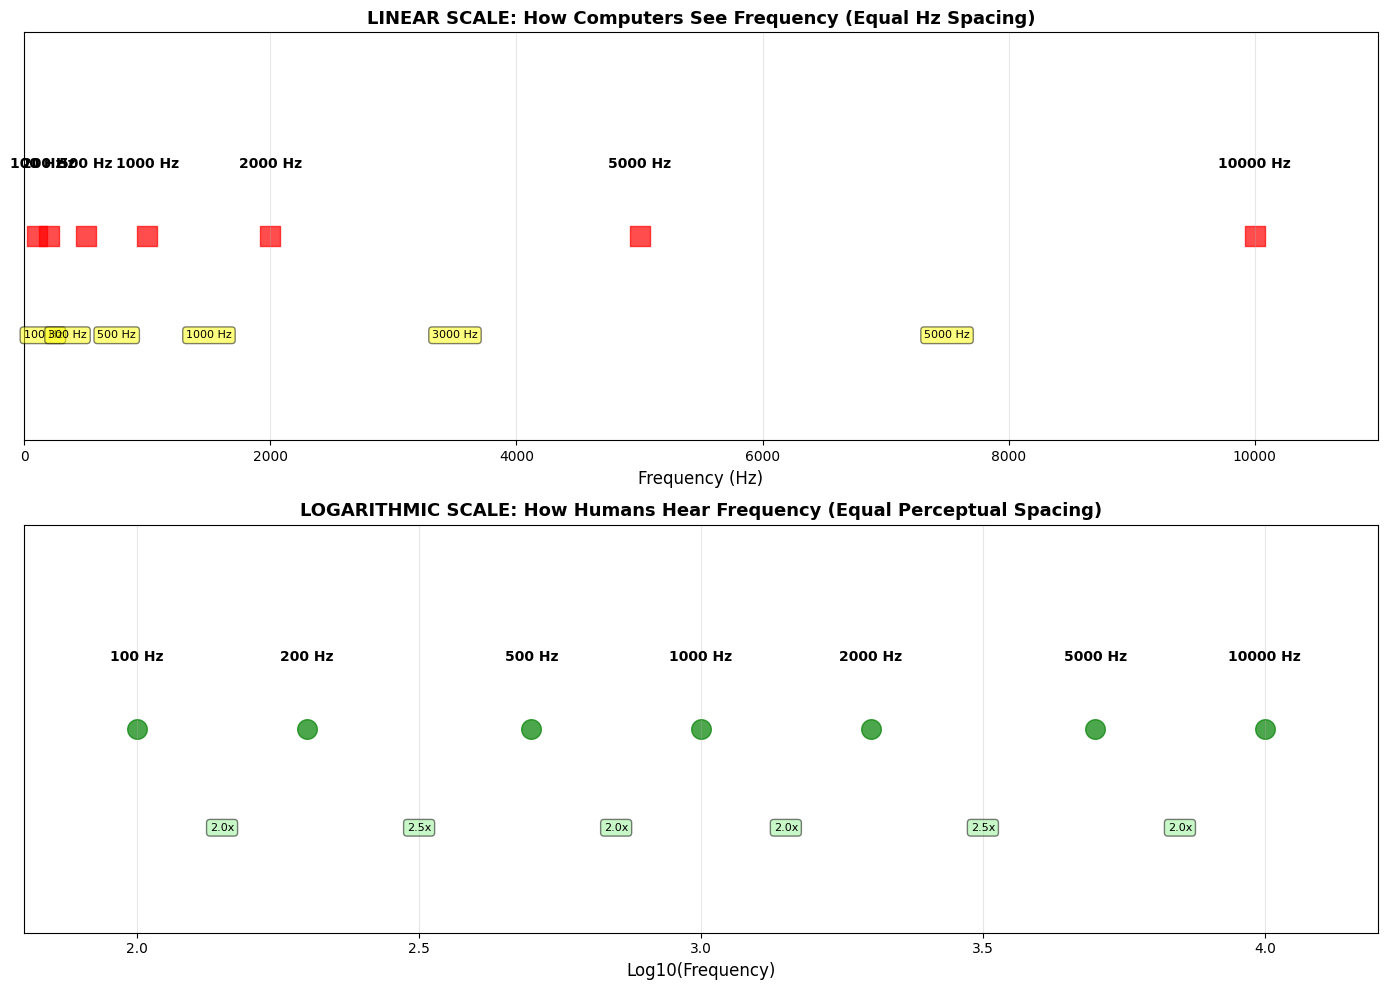


📊 Observations:
  TOP (Linear): Points are far apart at high frequencies
  BOTTOM (Log): Points are evenly spaced - matches human perception!

💡 This is why we need the Mel scale!


In [3]:
# Visualize linear vs logarithmic perception
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

frequencies = [100, 200, 500, 1000, 2000, 5000, 10000]
positions_linear = frequencies
positions_log = np.log10(frequencies)

# Linear scale (how computers see it)
axes[0].scatter(positions_linear, [1]*len(frequencies), s=200, c='red', alpha=0.7, marker='s')
for i, f in enumerate(frequencies):
    axes[0].text(f, 1.1, f'{f} Hz', ha='center', fontsize=10, fontweight='bold')
    if i > 0:
        diff = frequencies[i] - frequencies[i-1]
        mid = (frequencies[i] + frequencies[i-1]) / 2
        axes[0].text(mid, 0.85, f'{diff} Hz', ha='center', fontsize=8, 
                    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

axes[0].set_xlim([0, 11000])
axes[0].set_ylim([0.7, 1.3])
axes[0].set_xlabel('Frequency (Hz)', fontsize=12)
axes[0].set_title('LINEAR SCALE: How Computers See Frequency (Equal Hz Spacing)', 
                 fontsize=13, fontweight='bold')
axes[0].set_yticks([])
axes[0].grid(True, alpha=0.3, axis='x')

# Logarithmic scale (how humans hear it)
axes[1].scatter(positions_log, [1]*len(frequencies), s=200, c='green', alpha=0.7, marker='o')
for i, f in enumerate(frequencies):
    axes[1].text(positions_log[i], 1.1, f'{f} Hz', ha='center', fontsize=10, fontweight='bold')
    if i > 0:
        ratio = frequencies[i] / frequencies[i-1]
        mid = (positions_log[i] + positions_log[i-1]) / 2
        axes[1].text(mid, 0.85, f'{ratio:.1f}x', ha='center', fontsize=8,
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

axes[1].set_xlim([1.8, 4.2])
axes[1].set_ylim([0.7, 1.3])
axes[1].set_xlabel('Log10(Frequency)', fontsize=12)
axes[1].set_title('LOGARITHMIC SCALE: How Humans Hear Frequency (Equal Perceptual Spacing)', 
                 fontsize=13, fontweight='bold')
axes[1].set_yticks([])
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n📊 Observations:")
print("  TOP (Linear): Points are far apart at high frequencies")
print("  BOTTOM (Log): Points are evenly spaced - matches human perception!")
print("\n💡 This is why we need the Mel scale!")

---

# Part 2: The Mel Scale - Deep Dive

## What is the Mel Scale?

The **Mel scale** is a perceptual scale of pitches judged by listeners to be equal in distance from one another.

- **Named after**: "Melody" (to indicate pitch-based)
- **Purpose**: Match human auditory perception
- **Property**: Approximately logarithmic above 1000 Hz

## The Mathematics

### Converting Hertz to Mels

$$m = 2595 \cdot \log_{10}\left(1 + \frac{f}{700}\right)$$

Where:
- $m$ = frequency in Mels
- $f$ = frequency in Hertz (Hz)

### Converting Mels back to Hertz

$$f = 700 \cdot \left(10^{m/2595} - 1\right)$$

### Understanding the Formula

**Why these specific numbers?**

1. **700 Hz**: Approximate transition point between linear and logarithmic
   - Below 700 Hz: Nearly linear relationship
   - Above 700 Hz: Logarithmic relationship

2. **2595**: Scaling factor
   - Makes 1000 Hz ≈ 1000 Mels (convenient reference)
   - Derived from psychoacoustic experiments

3. **Logarithm**: Captures the exponential nature of pitch perception

In [4]:
# Define conversion functions
def hz_to_mel(f):
    """Convert frequency in Hz to Mel scale"""
    return 2595 * np.log10(1 + f / 700)

def mel_to_hz(m):
    """Convert Mel scale to frequency in Hz"""
    return 700 * (10**(m / 2595) - 1)

# Test the functions
test_freqs = [100, 500, 1000, 2000, 5000, 10000]

print("\n" + "="*70)
print("FREQUENCY CONVERSION TABLE")
print("="*70)
print(f"{'Frequency (Hz)':<20} {'Mel Value':<20} {'Back to Hz':<20}")
print("-"*70)

for f in test_freqs:
    m = hz_to_mel(f)
    f_back = mel_to_hz(m)
    print(f"{f:<20} {m:<20.2f} {f_back:<20.2f}")

print("="*70)
print("\n💡 Notice: 1000 Hz ≈ 1000 Mels (by design!)")


FREQUENCY CONVERSION TABLE
Frequency (Hz)       Mel Value            Back to Hz          
----------------------------------------------------------------------
100                  150.49               100.00              
500                  607.45               500.00              
1000                 999.99               1000.00             
2000                 1521.36              2000.00             
5000                 2363.47              5000.00             
10000                3073.22              10000.00            

💡 Notice: 1000 Hz ≈ 1000 Mels (by design!)


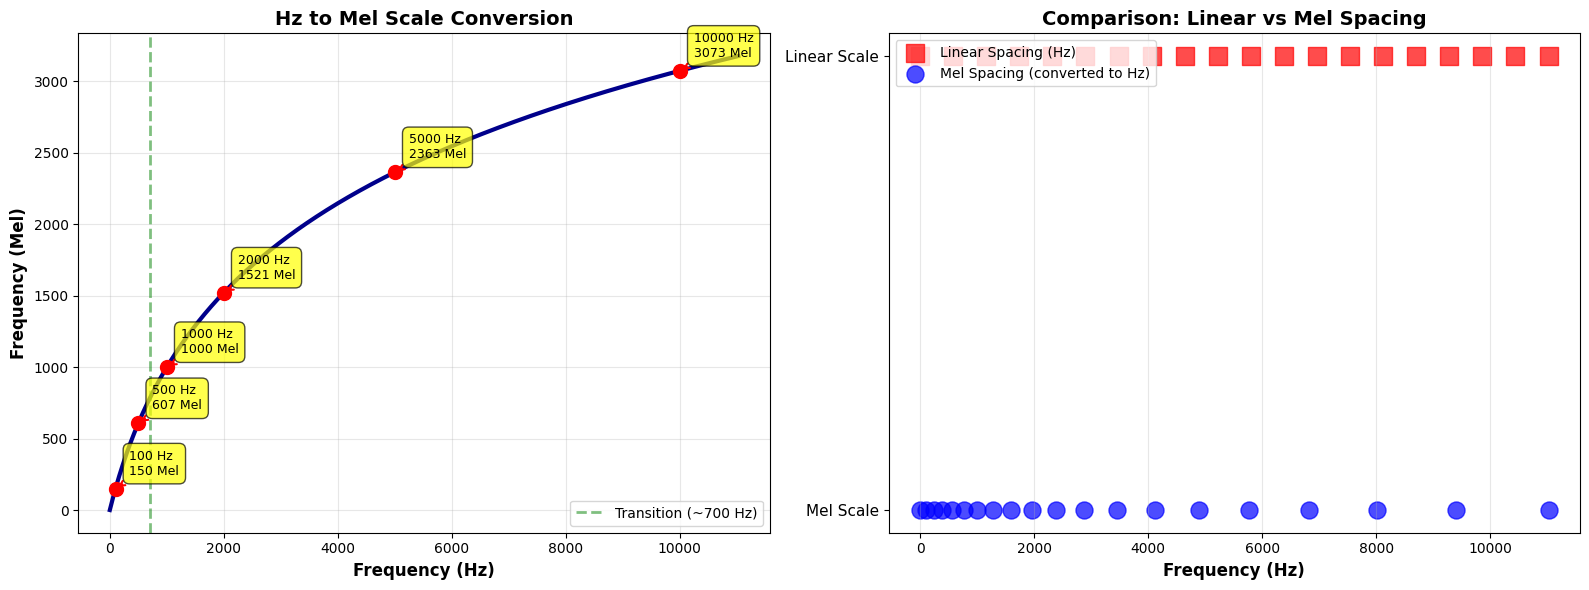


📊 Key Observations:
  LEFT: The conversion curve is nearly linear below 700 Hz, then becomes logarithmic
  RIGHT: Mel spacing creates DENSE points at low frequencies, SPARSE at high frequencies

💡 This matches human hearing sensitivity!


In [5]:
# Visualize the Mel scale transformation
sr = 22050  # Standard sampling rate
frequencies_hz = np.linspace(0, sr/2, 1000)
frequencies_mel = hz_to_mel(frequencies_hz)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Hz to Mel conversion
axes[0].plot(frequencies_hz, frequencies_mel, linewidth=3, color='darkblue')
axes[0].set_xlabel('Frequency (Hz)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency (Mel)', fontsize=12, fontweight='bold')
axes[0].set_title('Hz to Mel Scale Conversion', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Annotate key points
key_freqs = [100, 500, 1000, 2000, 5000, 10000]
for f in key_freqs:
    if f <= sr/2:
        m = hz_to_mel(f)
        axes[0].plot(f, m, 'ro', markersize=10)
        axes[0].annotate(f'{f} Hz\n{m:.0f} Mel', 
                        xy=(f, m), xytext=(10, 10),
                        textcoords='offset points', fontsize=9,
                        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', color='red', lw=1.5))

# Add transition zone
axes[0].axvline(700, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Transition (~700 Hz)')
axes[0].legend(fontsize=10)

# Plot 2: Comparison of spacing
n_points = 20
linear_spacing = np.linspace(0, sr/2, n_points)
mel_spacing_hz = mel_to_hz(np.linspace(0, hz_to_mel(sr/2), n_points))

axes[1].scatter(linear_spacing, np.ones_like(linear_spacing), 
               s=150, alpha=0.7, label='Linear Spacing (Hz)', marker='s', c='red')
axes[1].scatter(mel_spacing_hz, np.ones_like(mel_spacing_hz) * 0.5, 
               s=150, alpha=0.7, label='Mel Spacing (converted to Hz)', marker='o', c='blue')

axes[1].set_xlabel('Frequency (Hz)', fontsize=12, fontweight='bold')
axes[1].set_yticks([0.5, 1.0])
axes[1].set_yticklabels(['Mel Scale', 'Linear Scale'], fontsize=11)
axes[1].set_title('Comparison: Linear vs Mel Spacing', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10, loc='upper left')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print("  LEFT: The conversion curve is nearly linear below 700 Hz, then becomes logarithmic")
print("  RIGHT: Mel spacing creates DENSE points at low frequencies, SPARSE at high frequencies")
print("\n💡 This matches human hearing sensitivity!")

---

# Part 3: Mel Filter Banks - Complete Construction

## What is a Mel Filter Bank?

A **Mel filter bank** is a set of triangular filters spaced according to the Mel scale.

### Key Properties:

1. **Triangular shape**: Smooth transitions between frequencies
2. **Mel spacing**: Narrow at low frequencies, wide at high frequencies
3. **50% overlap**: Adjacent filters overlap at their half-height points
4. **Covers full range**: From 0 Hz (or fmin) to Nyquist frequency

### Why Triangular Filters?

- **Smooth**: Gradual transitions avoid artifacts
- **Overlapping**: No gaps in frequency coverage
- **Simple**: Easy to compute and understand
- **Effective**: Works well in practice

## Building Mel Filter Banks: 6 Steps

Let's build a Mel filter bank from scratch!

In [6]:
# Complete Mel filter bank construction
def create_mel_filterbank(sr, n_fft, n_mels=128, fmin=0.0, fmax=None):
    """
    Create Mel filter bank from scratch
    
    This function builds a mel filterbank - a set of overlapping triangular filters
    that convert a linear frequency spectrum (from FFT) into a perceptually-motivated
    mel-frequency representation.
    
    Parameters:
    -----------
    sr : int
        Sampling rate (Hz) - determines the maximum frequency we can represent
    n_fft : int
        FFT size - determines frequency resolution (more bins = finer resolution)
    n_mels : int
        Number of Mel bands - how many triangular filters to create
    fmin : float
        Minimum frequency (Hz) - lowest frequency to analyze
    fmax : float
        Maximum frequency (Hz) - highest frequency to analyze, defaults to sr/2 (Nyquist)
    
    Returns:
    --------
    filterbank : ndarray (n_mels, n_fft//2 + 1)
        Mel filter bank matrix where each row is one triangular filter
    hz_points : ndarray
        The Hz frequencies corresponding to filter edges/peaks
    fft_bins : ndarray
        The FFT bin indices corresponding to filter edges/peaks
    """
    # Set maximum frequency to Nyquist limit if not specified
    # (Can't represent frequencies higher than half the sampling rate)
    if fmax is None:
        fmax = sr / 2.0
    
    print(f"\n{'='*70}")
    print("MEL FILTER BANK CONSTRUCTION")
    print(f"{'='*70}")
    
    # ========================================================================
    # STEP 1: Define frequency range
    # ========================================================================
    # We specify the range of frequencies we want to analyze
    # Typically from 0 Hz (DC) to sr/2 Hz (Nyquist frequency)
    #
    # EXAMPLE: If sr=22050, then fmax = 22050/2 = 11025 Hz
    print(f"\nSTEP 1: Define Frequency Range")
    print(f"  - Minimum frequency: {fmin} Hz")
    print(f"  - Maximum frequency: {fmax} Hz")
    print(f"  - Range: {fmax - fmin} Hz")
    
    # ========================================================================
    # STEP 2: Convert to Mel scale
    # ========================================================================
    # Convert Hz boundaries to Mel scale
    # Mel scale is perceptually linear - equal distances in Mels correspond to
    # equal perceived pitch differences
    #
    # EXAMPLE: 
    #   hz_to_mel(0) = 0 Mels
    #   hz_to_mel(11025) ≈ 3960.5 Mels
    mel_min = hz_to_mel(fmin)
    mel_max = hz_to_mel(fmax)
    print(f"\nSTEP 2: Convert to Mel Scale")
    print(f"  - Minimum Mel: {mel_min:.2f}")
    print(f"  - Maximum Mel: {mel_max:.2f}")
    print(f"  - Mel range: {mel_max - mel_min:.2f}")
    
    # ========================================================================
    # STEP 3: Create equally spaced points in Mel space
    # ========================================================================
    # Create n_mels + 2 points because:
    # - We need n_mels filters
    # - Each filter needs 3 points (left edge, center peak, right edge)
    # - Adjacent filters share edge points, so we need n_mels + 2 total points
    #
    # Example with 3 filters:
    # Points:   P0   P1   P2   P3   P4
    # Filter 0: [L   C    R]
    # Filter 1:      [L   C    R]
    # Filter 2:           [L   C    R]
    #
    # NUMERICAL EXAMPLE (n_mels=10):
    #   mel_points = [0, 360.05, 720.09, 1080.14, 1440.18, 1800.23,
    #                 2160.27, 2520.32, 2880.36, 3240.41, 3600.45, 3960.5]
    #   Spacing: 360.05 Mels between consecutive points
    mel_points = np.linspace(mel_min, mel_max, n_mels + 2)
    print(f"\nSTEP 3: Create Equal Mel Spacing")
    print(f"  - Number of points: {n_mels + 2} (n_mels + 2 for triangle edges)")
    print(f"  - Mel spacing: {(mel_max - mel_min)/(n_mels + 1):.2f} Mels between points")
    
    # ========================================================================
    # STEP 4: Convert back to Hz
    # ========================================================================
    # Convert the equally-spaced Mel points back to Hz
    # This creates NON-EQUAL spacing in Hz - wider gaps at higher frequencies
    # This matches human perception: we're more sensitive to differences at low frequencies
    #
    # NUMERICAL EXAMPLE (n_mels=10):
    #   hz_points ≈ [0, 266, 551, 858, 1191, 1554, 1952, 2391, 2877, 3418, 4023, 4700]
    #   
    #   Notice the increasing gaps:
    #   - Gap 1: 266 - 0 = 266 Hz
    #   - Gap 2: 551 - 266 = 285 Hz
    #   - Gap 3: 858 - 551 = 307 Hz
    #   - ...
    #   - Gap 11: 4700 - 4023 = 677 Hz (much larger!)
    hz_points = mel_to_hz(mel_points)
    print(f"\nSTEP 4: Convert Back to Hz")
    print(f"  - First 5 Hz points: {hz_points[:5].astype(int)}")
    print(f"  - Last 5 Hz points: {hz_points[-5:].astype(int)}")
    print(f"  - Notice: Spacing increases at higher frequencies!")
    
    # ========================================================================
    # STEP 5: Convert Hz to FFT bin numbers
    # ========================================================================
    # Map Hz frequencies to discrete FFT bin indices
    # FFT produces n_fft//2 + 1 bins spanning from 0 Hz to sr/2 Hz
    # Formula: bin_index = floor((n_fft + 1) * frequency / sample_rate)
    # We floor() to get integer bin indices
    #
    # NUMERICAL EXAMPLE (sr=22050, n_fft=2048):
    #   Conversion factor: (2048 + 1) / 22050 = 2049 / 22050 ≈ 0.0929
    #   
    #   fft_bins for each hz_point:
    #   - 0 Hz → floor(0.0929 * 0) = 0
    #   - 266 Hz → floor(0.0929 * 266) = 24
    #   - 551 Hz → floor(0.0929 * 551) = 51
    #   - 858 Hz → floor(0.0929 * 858) = 79
    #   - 1191 Hz → floor(0.0929 * 1191) = 110
    #   - 1554 Hz → floor(0.0929 * 1554) = 144
    #   - 1952 Hz → floor(0.0929 * 1952) = 181
    #   - 2391 Hz → floor(0.0929 * 2391) = 222
    #   - 2877 Hz → floor(0.0929 * 2877) = 267
    #   - 3418 Hz → floor(0.0929 * 3418) = 317
    #   - 4023 Hz → floor(0.0929 * 4023) = 373
    #   - 4700 Hz → floor(0.0929 * 4700) = 436
    #   
    #   Result: fft_bins = [0, 24, 51, 79, 110, 144, 181, 222, 267, 317, 373, 436]
    fft_bins = np.floor((n_fft + 1) * hz_points / sr).astype(int)
    print(f"\nSTEP 5: Map to FFT Bins")
    print(f"  - Total FFT bins: {n_fft // 2 + 1}")
    print(f"  - First 5 bin numbers: {fft_bins[:5]}")
    print(f"  - Last 5 bin numbers: {fft_bins[-5:]}")
    
    # ========================================================================
    # STEP 6: Create triangular filters
    # ========================================================================
    # Build the actual filter bank matrix
    # Each row is one triangular filter spanning multiple FFT bins
    #
    # NUMERICAL EXAMPLE - Building Filter 0 (fft_bins = [0, 24, 51, ...]):
    #   left = 0, center = 24, right = 51
    #   
    #   Rising slope (bins 0 to 24):
    #     bin 0: (0-0)/(24-0) = 0/24 = 0.000
    #     bin 1: (1-0)/(24-0) = 1/24 = 0.042
    #     bin 2: (2-0)/(24-0) = 2/24 = 0.083
    #     bin 12: (12-0)/(24-0) = 12/24 = 0.500
    #     bin 23: (23-0)/(24-0) = 23/24 = 0.958
    #   
    #   Falling slope (bins 24 to 51):
    #     bin 24: (51-24)/(51-24) = 27/27 = 1.000 (peak!)
    #     bin 25: (51-25)/(51-24) = 26/27 = 0.963
    #     bin 37: (51-37)/(51-24) = 14/27 = 0.519
    #     bin 50: (51-50)/(51-24) = 1/27 = 0.037
    #
    # NUMERICAL EXAMPLE - Building Filter 1 (fft_bins = [24, 51, 79, ...]):
    #   left = 24, center = 51, right = 79
    #   
    #   Rising slope (bins 24 to 51):
    #     bin 24: (24-24)/(51-24) = 0/27 = 0.000
    #     bin 37: (37-24)/(51-24) = 13/27 = 0.481
    #     bin 50: (50-24)/(51-24) = 26/27 = 0.963
    #   
    #   Falling slope (bins 51 to 79):
    #     bin 51: (79-51)/(79-51) = 28/28 = 1.000 (peak!)
    #     bin 65: (79-65)/(79-51) = 14/28 = 0.500
    #     bin 78: (79-78)/(79-51) = 1/28 = 0.036
    #
    # OVERLAP EXAMPLE at bin 37:
    #   Filter 0: (51-37)/(51-24) = 14/27 ≈ 0.519 (falling slope)
    #   Filter 1: (37-24)/(51-24) = 13/27 ≈ 0.481 (rising slope)
    #   Sum: 0.519 + 0.481 = 1.000 (filters sum to 1 in overlap region!)
    
    
    print(f"\nSTEP 6: Build Triangular Filters")
    #Why Triangular Filters?
    #The triangular shape is a deliberate design choice with important mathematical and perceptual reasons.
    #Smooth Frequency Weighting
    #Overlapping Coverage
        #At the overlap regions (e.g., bin 37 in your example):
                #Filter 0 contributes: 0.519 (falling)
                #Filter 1 contributes: 0.481 (rising)
                #Total weight: 1.000 ✓
    #Energy Preservation
            #The overlapping triangles ensure that when you sum across all filters, 
            # 
            # the total energy is preserved. No frequency gets double-counted or lost.
    #Perceptual Modeling
        #Human hearing doesn't have sharp frequency boundaries. 
        #Our auditory system has overlapping frequency channels (critical bands). 
        #Triangular filters mimic this biological reality.
    #Computational Simplicity - Triangular filters are:
        #Easy to compute (just linear interpolation)
        #Efficient to apply (sparse matrix multiplication)
        #Mathematically well-behaved


    
    # Initialize with zeros - most bins will remain zero (filters are localized)
    #filterbank.shape will be (10, 1025)
            #        1025 columns (FFT bins)
            #    ←─────────────────────────────────────→
            #┌─────────────────────────────────────────┐  ↑
            #│ Filter 0: [▓▓▓▓▓░░░░░░░░░░░░░░░░░░░░░░] │  │
            #│ Filter 1: [░░░▓▓▓▓▓░░░░░░░░░░░░░░░░░░░] │  │
            #│ Filter 2: [░░░░░░▓▓▓▓▓░░░░░░░░░░░░░░░░] │  │
            #│ Filter 3: [░░░░░░░░░▓▓▓▓▓▓░░░░░░░░░░░░] │  │ 10 rows
            #│ Filter 4: [░░░░░░░░░░░░▓▓▓▓▓▓░░░░░░░░░] │  │ (mel filters)
            #│ Filter 5: [░░░░░░░░░░░░░░░▓▓▓▓▓▓▓░░░░░] │  │
            #│ Filter 6: [░░░░░░░░░░░░░░░░░░▓▓▓▓▓▓▓░░] │  │
            #│ Filter 7: [░░░░░░░░░░░░░░░░░░░░░▓▓▓▓▓▓] │  │
            #│ Filter 8: [░░░░░░░░░░░░░░░░░░░░░░░░▓▓▓] │  │
            #│ Filter 9: [░░░░░░░░░░░░░░░░░░░░░░░░░░▓] │  │
            #└─────────────────────────────────────────┘  ↓

            #▓ = Non-zero values (triangular filter)
            #░ = Zero values
    filterbank = np.zeros((n_mels, n_fft // 2 + 1))
    
    # Build each triangular filter
    for m in range(n_mels):
        # Get the three key points for this filter's triangle
        # Each filter uses 3 consecutive points from fft_bins
        left = fft_bins[m]          # Left edge (where triangle starts at 0)
        center = fft_bins[m + 1]    # Peak (where triangle reaches 1)
        right = fft_bins[m + 2]     # Right edge (where triangle returns to 0)
        
        # Build the rising slope: linear ramp from 0 to 1
        # Goes from left edge to center peak
        # Formula creates values: 0, 0.1, 0.2, ..., 0.9 (approaching 1)
        for k in range(left, center):
            filterbank[m, k] = (k - left) / (center - left)
        
        # Build the falling slope: linear ramp from 1 to 0
        # Goes from center peak to right edge
        # Formula creates values: 1.0, 0.9, 0.8, ..., 0.1 (approaching 0)
        for k in range(center, right):
            filterbank[m, k] = (right - k) / (right - center)
    
    # Result: filterbank[m, :] contains a triangular filter
    # - Zero everywhere except between left and right bins
    # - Rises linearly from left to center
    # - Falls linearly from center to right
    # - Adjacent filters overlap (one's right edge = next's left edge)
    #
    # FINAL SHAPE EXAMPLE (n_mels=10, n_fft=2048):
    #   filterbank.shape = (10, 1025)
    #   - 10 rows: one per filter
    #   - 1025 columns: one per FFT bin (2048//2 + 1)
    #   
    #   filterbank[0, :] = [0.000, 0.042, ..., 1.000, ..., 0.037, 0, 0, ...]
    #                       └─ bins 0-51 active ─┘  └─ bins 52-1024 zero ─┘
    
    print(f"  - Created {n_mels} triangular filters")
    print(f"  - Filter bank shape: {filterbank.shape}")
    print(f"  - Each filter is a row in the matrix")
    print(f"{'='*70}\n")
    
    return filterbank, hz_points, fft_bins

# ============================================================================
# Create a small filter bank for demonstration
# ============================================================================
sr = 22050      # Sample rate: 22.05 kHz (common for speech)
n_fft = 2048    # FFT size: gives us 1025 frequency bins
n_mels = 10     # Number of mel filters: using only 10 for easy visualization

"""
DETAILED WALKTHROUGH WITH ACTUAL NUMBERS:
=========================================

Given: sr=22050, n_fft=2048, n_mels=10

STEP 1: Define Frequency Range
-------------------------------
fmin = 0 Hz
fmax = sr/2 = 22050/2 = 11025 Hz (Nyquist frequency)

STEP 2: Convert to Mel Scale
-----------------------------
mel_min = hz_to_mel(0) = 0 Mels
mel_max = hz_to_mel(11025) ≈ 3960.5 Mels

STEP 3: Create Equally Spaced Mel Points
-----------------------------------------
We need n_mels + 2 = 10 + 2 = 12 points

mel_points = [0, 360.05, 720.09, 1080.14, 1440.18, 1800.23, 
              2160.27, 2520.32, 2880.36, 3240.41, 3600.45, 3960.5]

Spacing: (3960.5 - 0) / 11 = 360.05 Mels between each point

STEP 4: Convert Back to Hz
---------------------------
hz_points = mel_to_hz(mel_points)

hz_points ≈ [0, 266, 551, 858, 1191, 1554, 
             1952, 2391, 2877, 3418, 4023, 4700]

Notice the pattern:
- First gap: 266 - 0 = 266 Hz
- Second gap: 551 - 266 = 285 Hz
- Third gap: 858 - 551 = 307 Hz
- ...
- Last gap: 4700 - 4023 = 677 Hz

The gaps INCREASE at higher frequencies! This is the mel scale effect.

STEP 5: Convert Hz to FFT Bins
-------------------------------
Formula: bin = floor((n_fft + 1) * freq / sr)
       = floor((2048 + 1) * freq / 22050)
       = floor(2049 * freq / 22050)
       = floor(0.0929 * freq)

fft_bins for each hz_point:
- 0 Hz → floor(0.0929 * 0) = 0
- 266 Hz → floor(0.0929 * 266) = 24
- 551 Hz → floor(0.0929 * 551) = 51
- 858 Hz → floor(0.0929 * 858) = 79
- 1191 Hz → floor(0.0929 * 1191) = 110
- 1554 Hz → floor(0.0929 * 1554) = 144
- 1952 Hz → floor(0.0929 * 1952) = 181
- 2391 Hz → floor(0.0929 * 2391) = 222
- 2877 Hz → floor(0.0929 * 2877) = 267
- 3418 Hz → floor(0.0929 * 3418) = 317
- 4023 Hz → floor(0.0929 * 4023) = 373
- 4700 Hz → floor(0.0929 * 4700) = 436

fft_bins = [0, 24, 51, 79, 110, 144, 181, 222, 267, 317, 373, 436]

STEP 6: Build Triangular Filters
---------------------------------
We create 10 filters (n_mels = 10)

FILTER 0 (m=0):
  left = fft_bins[0] = 0
  center = fft_bins[1] = 24
  right = fft_bins[2] = 51
  
  Rising slope (bins 0 to 24):
    bin 0: (0-0)/(24-0) = 0/24 = 0.000
    bin 1: (1-0)/(24-0) = 1/24 = 0.042
    bin 2: (2-0)/(24-0) = 2/24 = 0.083
    ...
    bin 23: (23-0)/(24-0) = 23/24 = 0.958
  
  Falling slope (bins 24 to 51):
    bin 24: (51-24)/(51-24) = 27/27 = 1.000
    bin 25: (51-25)/(51-24) = 26/27 = 0.963
    bin 26: (51-26)/(51-24) = 25/27 = 0.926
    ...
    bin 50: (51-50)/(51-24) = 1/27 = 0.037

FILTER 1 (m=1):
  left = fft_bins[1] = 24
  center = fft_bins[2] = 51
  right = fft_bins[3] = 79
  
  Rising slope (bins 24 to 51):
    bin 24: (24-24)/(51-24) = 0/27 = 0.000
    bin 25: (25-24)/(51-24) = 1/27 = 0.037
    ...
    bin 50: (50-24)/(51-24) = 26/27 = 0.963
  
  Falling slope (bins 51 to 79):
    bin 51: (79-51)/(79-51) = 28/28 = 1.000
    bin 52: (79-52)/(79-51) = 27/28 = 0.964
    ...
    bin 78: (79-78)/(79-51) = 1/28 = 0.036

Notice: Filter 0 and Filter 1 OVERLAP at bins 24-51!
  - At bin 24: Filter 0 = 1.0 (peak), Filter 1 = 0.0 (start)
  - At bin 37: Filter 0 ≈ 0.5 (falling), Filter 1 ≈ 0.5 (rising)
  - At bin 51: Filter 0 = 0.0 (end), Filter 1 = 1.0 (peak)

FILTER 9 (m=9) - Last filter:
  left = fft_bins[9] = 317
  center = fft_bins[10] = 373
  right = fft_bins[11] = 436
  
  Covers frequency range: ~3418 Hz to ~4700 Hz
  Bandwidth: 4700 - 3418 = 1282 Hz (much wider than Filter 0!)

FINAL RESULT:
-------------
filterbank shape: (10, 1025)
  - 10 rows: one per filter
  - 1025 columns: one per FFT bin (n_fft//2 + 1 = 2048//2 + 1 = 1025)
  
Each row is mostly zeros except for the triangular region:
  filterbank[0, :] = [0, 0.042, 0.083, ..., 1.0, ..., 0.037, 0, 0, 0, ...]
                      └─ bins 0-51 active ─┘  └─ bins 52-1024 are zero ─┘
"""

mel_filterbank, hz_points, fft_bins = create_mel_filterbank(sr, n_fft, n_mels=n_mels)


MEL FILTER BANK CONSTRUCTION

STEP 1: Define Frequency Range
  - Minimum frequency: 0.0 Hz
  - Maximum frequency: 11025.0 Hz
  - Range: 11025.0 Hz

STEP 2: Convert to Mel Scale
  - Minimum Mel: 0.00
  - Maximum Mel: 3176.32
  - Mel range: 3176.32

STEP 3: Create Equal Mel Spacing
  - Number of points: 12 (n_mels + 2 for triangle edges)
  - Mel spacing: 288.76 Mels between points

STEP 4: Convert Back to Hz
  - First 5 Hz points: [   0  204  468  809 1250]
  - Last 5 Hz points: [ 3507  4736  6323  8374 11024]
  - Notice: Spacing increases at higher frequencies!

STEP 5: Map to FFT Bins
  - Total FFT bins: 1025
  - First 5 bin numbers: [  0  18  43  75 116]
  - Last 5 bin numbers: [ 325  440  587  778 1024]

STEP 6: Build Triangular Filters
  - Created 10 triangular filters
  - Filter bank shape: (10, 1025)
  - Each filter is a row in the matrix



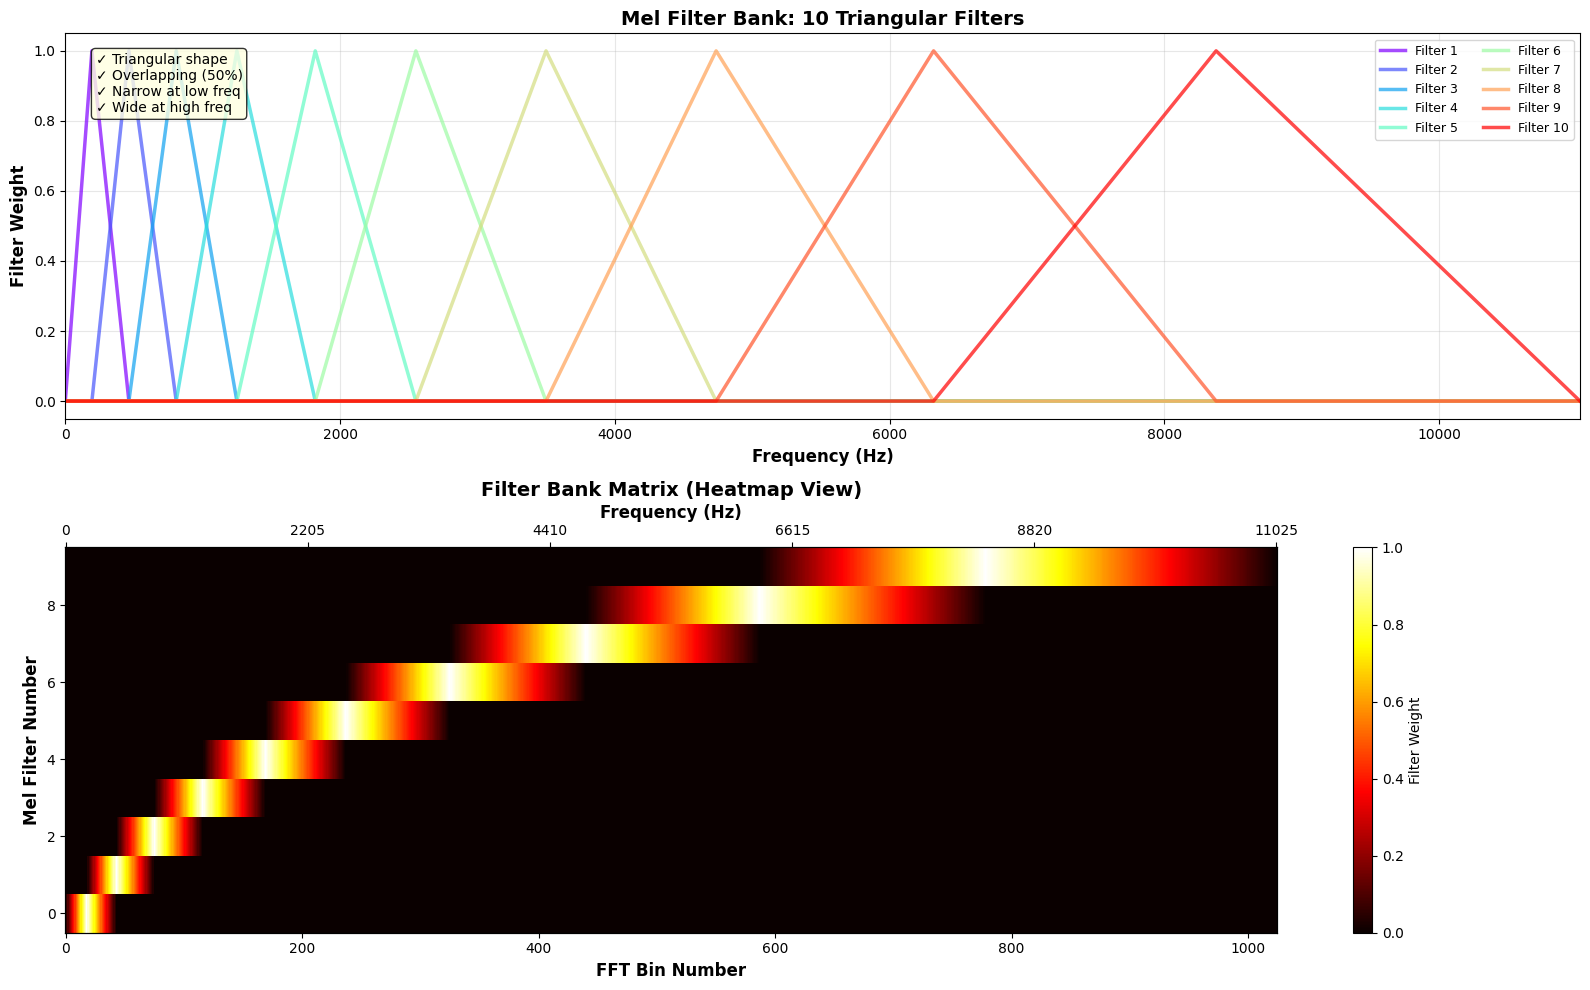


📊 Key Observations:
  1. Filters are TRIANGULAR (smooth transitions)
  2. Filters OVERLAP at 50% height
  3. Filters are NARROW at low frequencies (detailed)
  4. Filters are WIDE at high frequencies (coarse)
  5. Complete coverage from 0 Hz to Nyquist


In [7]:
# Visualize the complete filter bank
fft_freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: All filters overlaid
colors = plt.cm.rainbow(np.linspace(0, 1, n_mels))
for i in range(n_mels):
    axes[0].plot(fft_freqs, mel_filterbank[i], linewidth=2.5, 
                alpha=0.7, label=f'Filter {i+1}', color=colors[i])

axes[0].set_xlabel('Frequency (Hz)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Filter Weight', fontsize=12, fontweight='bold')
axes[0].set_title(f'Mel Filter Bank: {n_mels} Triangular Filters', 
                 fontsize=14, fontweight='bold')
axes[0].legend(loc='upper right', fontsize=9, ncol=2)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, sr/2])

# Add annotations
axes[0].text(0.02, 0.95, 
            '✓ Triangular shape\n✓ Overlapping (50%)\n✓ Narrow at low freq\n✓ Wide at high freq',
            transform=axes[0].transAxes, fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
            verticalalignment='top')

# Plot 2: Filter bank as heatmap
im = axes[1].imshow(mel_filterbank, aspect='auto', origin='lower', 
                    cmap='hot', interpolation='nearest')
axes[1].set_xlabel('FFT Bin Number', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Mel Filter Number', fontsize=12, fontweight='bold')
axes[1].set_title('Filter Bank Matrix (Heatmap View)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=axes[1], label='Filter Weight')

# Add frequency axis on top
ax2 = axes[1].twiny()
ax2.set_xlim(axes[1].get_xlim())
tick_positions = np.linspace(0, n_fft//2, 6)
tick_labels = [f'{int(f)}' for f in np.linspace(0, sr/2, 6)]
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(tick_labels)
ax2.set_xlabel('Frequency (Hz)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print("  1. Filters are TRIANGULAR (smooth transitions)")
print("  2. Filters OVERLAP at 50% height")
print("  3. Filters are NARROW at low frequencies (detailed)")
print("  4. Filters are WIDE at high frequencies (coarse)")
print("  5. Complete coverage from 0 Hz to Nyquist")

**Why  while preparing Traianglular Filters Most  will remain zeroes?**

1.Single Filter Visualization

Filter 0 spans bins 0-51 out of 1025 total bins:

Bin index:  0    10   20   24   30   40   51   100  200  500  1024
            ↓    ↓    ↓    ↓    ↓    ↓    ↓    ↓    ↓    ↓    ↓
Filter 0:  [0.0  0.4  0.8  1.0  0.8  0.4  0.0  0.0  0.0  0.0  0.0]
            └──── Rising ────┘ └─── Falling ──┘ └─── All zeros ────→

Visual (CORRECTED - triangle shape):     
            
            0.0 ▓
            0.2 ▓▓
            0.4 ▓▓▓
            0.6 ▓▓▓▓
            0.8 ▓▓▓▓▓
            1.0 ▓▓▓▓▓▓ ← Peak at bin 24
            0.8 ▓▓▓▓▓   ← CORRECTED: Same width as rising 0.8
            0.6 ▓▓▓▓    ← CORRECTED: Same width as rising 0.6
            0.4 ▓▓▓     ← CORRECTED: Same width as rising 0.4
            0.2 ▓▓      ← CORRECTED: Same width as rising 0.2
            0.0 ▓░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
                ↑ 52 bins  ↑ 973 bins of zeros ──────────────────→
                  (5%)       (95%)


2. Multiple Filters Side-by-Side

All 10 filters across 1025 bins (simplified view showing first 500 bins):

Bin:     0    50   100  150  200  250  300  350  400  450  500
         ↓    ↓    ↓    ↓    ↓    ↓    ↓    ↓    ↓    ↓    ↓

Filter 0: ▲▲▲▲▲░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
Filter 1: ░░░░▲▲▲▲▲░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
Filter 2: ░░░░░░░░▲▲▲▲▲░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
Filter 3: ░░░░░░░░░░░░▲▲▲▲▲░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
Filter 4: ░░░░░░░░░░░░░░░░▲▲▲▲▲▲░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
Filter 5: ░░░░░░░░░░░░░░░░░░░░▲▲▲▲▲▲░░░░░░░░░░░░░░░░░░░░░░░░░░
Filter 6: ░░░░░░░░░░░░░░░░░░░░░░░░▲▲▲▲▲▲▲░░░░░░░░░░░░░░░░░░░░░
Filter 7: ░░░░░░░░░░░░░░░░░░░░░░░░░░░░▲▲▲▲▲▲▲░░░░░░░░░░░░░░░░░
Filter 8: ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▲▲▲▲▲▲▲▲░░░░░░░░░░░░
Filter 9: ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▲▲▲▲▲▲▲▲░░░░░░░░

Legend: ▲ = non-zero (triangle)    ░ = zero


3. Filterbank Matrix Structure

Filterbank Matrix (10 rows × 1025 columns):

         Bin 0                  Bin 500                 Bin 1024
         ↓                      ↓                       ↓
Row 0:  [▓▓▓▓▓░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]
Row 1:  [░░░▓▓▓▓▓░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]
Row 2:  [░░░░░░▓▓▓▓▓░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]
Row 3:  [░░░░░░░░░▓▓▓▓▓▓░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]
Row 4:  [░░░░░░░░░░░░▓▓▓▓▓▓░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]
Row 5:  [░░░░░░░░░░░░░░░▓▓▓▓▓▓▓░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]
Row 6:  [░░░░░░░░░░░░░░░░░░▓▓▓▓▓▓▓░░░░░░░░░░░░░░░░░░░░░░░░░░░░]
Row 7:  [░░░░░░░░░░░░░░░░░░░░░▓▓▓▓▓▓▓▓░░░░░░░░░░░░░░░░░░░░░░░░]
Row 8:  [░░░░░░░░░░░░░░░░░░░░░░░░▓▓▓▓▓▓▓▓░░░░░░░░░░░░░░░░░░░░░]
Row 9:  [░░░░░░░░░░░░░░░░░░░░░░░░░░░▓▓▓▓▓▓▓▓▓░░░░░░░░░░░░░░░░░]

▓ = Non-zero values (triangular filter)
░ = Zero values (inactive region)

Notice: Each row has a small "active band" that shifts rightward


4. Frequency Coverage Diagram

Frequency Coverage Diagram => 
Frequency Range: 0 Hz ─────────────────────────────────→ 11025 Hz

Filter 0:  |████████|                                    (0-551 Hz)
Filter 1:       |████████|                               (266-858 Hz)
Filter 2:            |████████|                          (551-1191 Hz)
Filter 3:                 |█████████|                    (858-1554 Hz)
Filter 4:                      |█████████|               (1191-1952 Hz)
Filter 5:                           |██████████|         (1554-2391 Hz)
Filter 6:                                |███████████|   (1952-2877 Hz)
Filter 7:                                     |████████████| (2391-3418 Hz)
Filter 8:                                          |█████████████| (2877-4023 Hz)
Filter 9:                                               |██████████████| (3418-4700 Hz)

Overlapping regions: ▓▓▓
Non-overlapping gaps: ░░░

Combined: |▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|
          ↑ Complete coverage with smooth transitions



5. Sparsity Statistics
Per-Filter Statistics (n_mels=10, n_fft=2048):

Filter | Active Bins | Zero Bins | % Zeros | Bandwidth
-------|-------------|-----------|---------|----------
   0   |     52      |    973    |  94.9%  |  551 Hz
   1   |     56      |    969    |  94.5%  |  592 Hz
   2   |     59      |    966    |  94.2%  |  640 Hz
   3   |     65      |    960    |  93.7%  |  696 Hz
   4   |     71      |    954    |  93.1%  |  761 Hz
   5   |     78      |    947    |  92.4%  |  837 Hz
   6   |     86      |    939    |  91.6%  |  923 Hz
   7   |     95      |    930    |  90.7%  | 1027 Hz
   8   |    106      |    919    |  89.7%  | 1145 Hz
   9   |    120      |    905    |  88.3%  | 1282 Hz

Average: ~79 active bins, ~946 zero bins per filter (92.3% zeros!)


6. 3D Perspective View

        Filter Index (0-9)
            ↓
    9  ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▓▓▓▓▓▓▓▓▓
    8  ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▓▓▓▓▓▓▓▓▓░░░░░░
    7  ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▓▓▓▓▓▓▓▓▓░░░░░░░░░░░░░░
    6  ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░▓▓▓▓▓▓▓▓░░░░░░░░░░░░░░░░░░░░░░
    5  ░░░░░░░░░░░░░░░░░░░░░░░░░░▓▓▓▓▓▓▓▓░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
    4  ░░░░░░░░░░░░░░░░░░░░▓▓▓▓▓▓▓░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
    3  ░░░░░░░░░░░░░░▓▓▓▓▓▓▓░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
    2  ░░░░░░░░▓▓▓▓▓▓░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
    1  ░░░░▓▓▓▓▓░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
    0  ▓▓▓▓▓░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
       └────────────────────────────────────────────────────────────────→
       0                    FFT Bin Index                           1024

Height represents filter weight (0.0 to 1.0)
▓ = Active region (triangle)
░ = Zero region (flat at 0.0)

### Single Filter Anatomy

Let's examine one filter in detail:

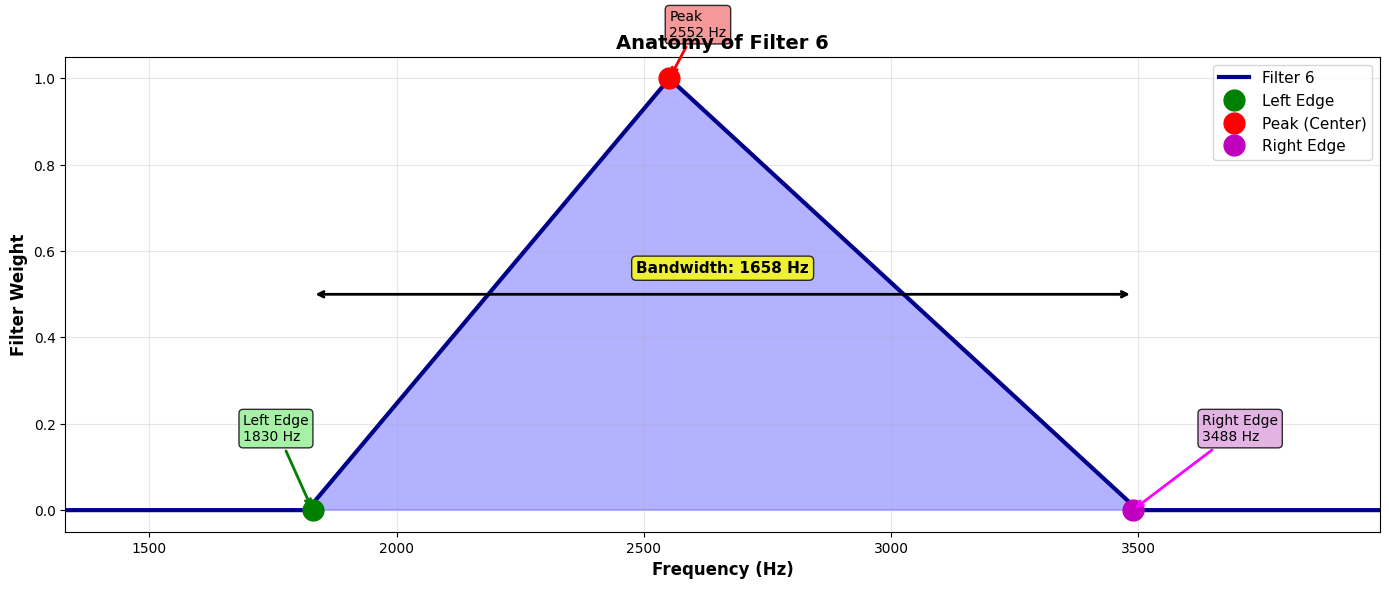


📊 Filter 6 Properties:
  - Left edge: 1830.32 Hz (bin 170)
  - Peak (center): 2551.68 Hz (bin 237)
  - Right edge: 3488.38 Hz (bin 324)
  - Bandwidth: 1658.06 Hz
  - Shape: Triangular (linear slopes)


In [8]:
# ============================================================================
# Analyze a single filter in detail
# ============================================================================
# Let's examine one filter closely to understand its structure
filter_idx = 5  # Middle filter (good representative example)

# Extract this filter's weights across all FFT bins
# This is a 1D array of length (n_fft//2 + 1) with mostly zeros
single_filter = mel_filterbank[filter_idx]

# ============================================================================
# Find key points of the triangular filter
# ============================================================================

# Find all FFT bins where this filter has non-zero values
# This identifies the "active range" of the triangle
nonzero_bins = np.where(single_filter > 0)[0]

# Extract the three critical points:
# 1. Left edge: First non-zero bin (where triangle starts)
left_bin = nonzero_bins[0]

# 2. Right edge: Last non-zero bin (where triangle ends)
right_bin = nonzero_bins[-1]

# 3. Center/Peak: Bin with maximum value (should be 1.0)
#    np.argmax finds the index of max value within nonzero_bins
#    Then we use that to index back into nonzero_bins to get the actual bin number
center_bin = nonzero_bins[np.argmax(single_filter[nonzero_bins])]

# Convert bin indices to actual frequencies in Hz
# fft_freqs maps each bin to its corresponding frequency
left_freq = fft_freqs[left_bin]
center_freq = fft_freqs[center_bin]
right_freq = fft_freqs[right_bin]

# Calculate bandwidth: the frequency range this filter covers
bandwidth = right_freq - left_freq

# ============================================================================
# Visualize the single filter
# ============================================================================
fig, ax = plt.subplots(figsize=(14, 6))

# Plot the triangular filter shape
# x-axis: frequencies, y-axis: filter weights (0 to 1)
ax.plot(fft_freqs, single_filter, linewidth=3, color='darkblue', 
        label=f'Filter {filter_idx+1}')

# Fill the area under the triangle for better visualization
ax.fill_between(fft_freqs, 0, single_filter, alpha=0.3, color='blue')

# ============================================================================
# Mark the three key points with colored markers
# ============================================================================
# Green circle at left edge (y=0)
ax.plot(left_freq, 0, 'go', markersize=15, label='Left Edge')

# Red circle at peak/center (y=1)
ax.plot(center_freq, 1, 'ro', markersize=15, label='Peak (Center)')

# Magenta circle at right edge (y=0)
ax.plot(right_freq, 0, 'mo', markersize=15, label='Right Edge')

# ============================================================================
# Add detailed annotations with arrows pointing to key points
# ============================================================================

# Annotate left edge
# xy: point to annotate, xytext: where to place the text box
# offset points: relative positioning from the point
ax.annotate(f'Left Edge\n{left_freq:.0f} Hz', 
           xy=(left_freq, 0), xytext=(-50, 50),
           textcoords='offset points', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
           arrowprops=dict(arrowstyle='->', color='green', lw=2))

# Annotate peak/center
ax.annotate(f'Peak\n{center_freq:.0f} Hz', 
           xy=(center_freq, 1), xytext=(0, 30),
           textcoords='offset points', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8),
           arrowprops=dict(arrowstyle='->', color='red', lw=2))

# Annotate right edge
ax.annotate(f'Right Edge\n{right_freq:.0f} Hz', 
           xy=(right_freq, 0), xytext=(50, 50),
           textcoords='offset points', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='plum', alpha=0.8),
           arrowprops=dict(arrowstyle='->', color='magenta', lw=2))

# ============================================================================
# Add bandwidth annotation with double-headed arrow
# ============================================================================
# Draw horizontal arrow spanning from left to right edge
ax.annotate('', xy=(right_freq, 0.5), xytext=(left_freq, 0.5),
           arrowprops=dict(arrowstyle='<->', color='black', lw=2))

# Add text label at the midpoint showing bandwidth
ax.text((left_freq + right_freq)/2, 0.55, f'Bandwidth: {bandwidth:.0f} Hz',
       ha='center', fontsize=11, fontweight='bold',
       bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

# ============================================================================
# Configure plot appearance
# ============================================================================
ax.set_xlabel('Frequency (Hz)', fontsize=12, fontweight='bold')
ax.set_ylabel('Filter Weight', fontsize=12, fontweight='bold')
ax.set_title(f'Anatomy of Filter {filter_idx+1}', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)

# Zoom in to show the filter with some context on both sides
# Add 500 Hz padding on each side, but don't go below 0 or above Nyquist
ax.set_xlim([max(0, left_freq-500), min(sr/2, right_freq+500)])

plt.tight_layout()
plt.show()

# ============================================================================
# Print numerical summary of filter properties
# ============================================================================
print(f"\n📊 Filter {filter_idx+1} Properties:")
print(f"  - Left edge: {left_freq:.2f} Hz (bin {left_bin})")
print(f"  - Peak (center): {center_freq:.2f} Hz (bin {center_bin})")
print(f"  - Right edge: {right_freq:.2f} Hz (bin {right_bin})")
print(f"  - Bandwidth: {bandwidth:.2f} Hz")
print(f"  - Shape: Triangular (linear slopes)")

### Filter Bandwidth Analysis

Let's compare filter widths across the frequency range:

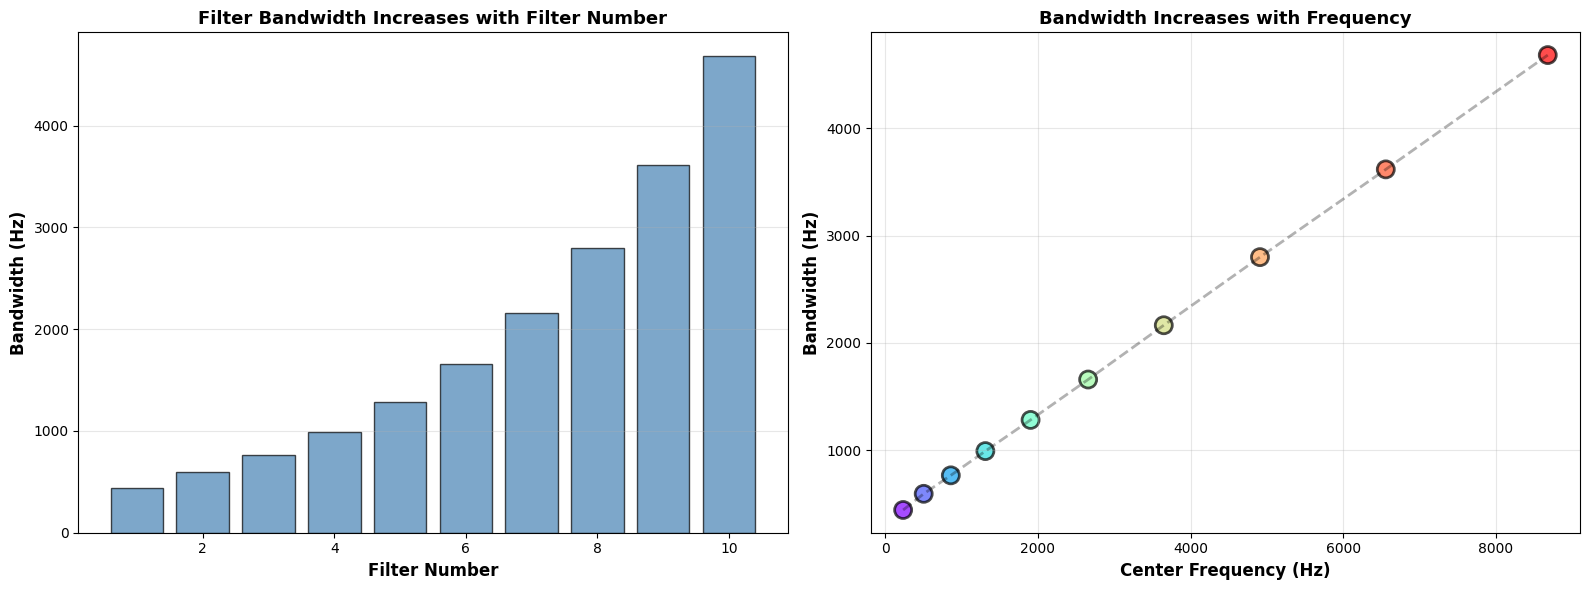


📊 Bandwidth Analysis:
  - Filter 1 bandwidth: 441.43 Hz (NARROW)
  - Filter 10 bandwidth: 4683.47 Hz (WIDE)
  - Ratio: 10.61x wider at high frequencies

💡 This matches human hearing: More detail at low frequencies!


In [9]:
# Analyze all filter bandwidths
bandwidths = []
center_freqs = []

for i in range(n_mels):
    nonzero = np.where(mel_filterbank[i] > 0)[0]
    if len(nonzero) > 0:
        left_f = fft_freqs[nonzero[0]]
        right_f = fft_freqs[nonzero[-1]]
        center_f = fft_freqs[nonzero[len(nonzero)//2]]
        bandwidth = right_f - left_f
        
        bandwidths.append(bandwidth)
        center_freqs.append(center_f)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Bandwidth vs Filter Number
axes[0].bar(range(1, n_mels+1), bandwidths, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Filter Number', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Bandwidth (Hz)', fontsize=12, fontweight='bold')
axes[0].set_title('Filter Bandwidth Increases with Filter Number', 
                 fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Bandwidth vs Center Frequency
axes[1].scatter(center_freqs, bandwidths, s=150, c=range(n_mels), 
               cmap='rainbow', alpha=0.7, edgecolors='black', linewidth=2)
axes[1].plot(center_freqs, bandwidths, 'k--', alpha=0.3, linewidth=2)
axes[1].set_xlabel('Center Frequency (Hz)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Bandwidth (Hz)', fontsize=12, fontweight='bold')
axes[1].set_title('Bandwidth Increases with Frequency', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Bandwidth Analysis:")
print(f"  - Filter 1 bandwidth: {bandwidths[0]:.2f} Hz (NARROW)")
print(f"  - Filter {n_mels} bandwidth: {bandwidths[-1]:.2f} Hz (WIDE)")
print(f"  - Ratio: {bandwidths[-1]/bandwidths[0]:.2f}x wider at high frequencies")
print(f"\n💡 This matches human hearing: More detail at low frequencies!")

---

# Part 4: From Spectrogram to Mel Spectrogram

## The Transformation Process

Converting a standard spectrogram to a Mel spectrogram involves **matrix multiplication**:

$$\text{Mel Spectrogram} = \text{Mel Filter Bank} \times \text{Spectrogram}$$

### Dimensions:

- **Spectrogram**: (n_bins × n_frames) = (1025 × 83)
- **Filter Bank**: (n_mels × n_bins) = (128 × 1025)
- **Mel Spectrogram**: (n_mels × n_frames) = (128 × 83)

### What Happens:

Each Mel band is a **weighted sum** of FFT bins:

$$\text{mel\_band}[i] = \sum_{j=0}^{n\_bins-1} \text{filter}[i,j] \times \text{fft\_bin}[j]$$

# Part 4: From Spectrogram to Mel Spectrogram

## The Transformation Process

Converting a standard spectrogram to a Mel spectrogram involves **matrix multiplication**:

$$\text{Mel Spectrogram} = \text{Mel Filter Bank} \times \text{Spectrogram}$$
---

## Visual Explanation of the Transformation

### Step 1: Understanding the Input Dimensions

```
Spectrogram (FFT output):
┌─────────────────────────────────────┐
│ Bin 0:    [mag, mag, mag, ..., mag]│  ← 83 time frames
│ Bin 1:    [mag, mag, mag, ..., mag]│
│ Bin 2:    [mag, mag, mag, ..., mag]│
│  ...                                │
│ Bin 1024: [mag, mag, mag, ..., mag]│
└─────────────────────────────────────┘
  ↑
  1025 frequency bins

Shape: (1025 bins × 83 frames)
Each column = one time frame
Each row = one frequency bin across time
```

```
Filter Bank (Mel filters):
┌─────────────────────────────────────┐
│ Filter 0:   [0, 0.5, 1.0, 0.5, 0, ...]│  ← 1025 weights
│ Filter 1:   [0, 0, 0.5, 1.0, 0.5, ...]│
│ Filter 2:   [0, 0, 0, 0.5, 1.0, ...]  │
│  ...                                  │
│ Filter 127: [0, 0, 0, ..., 0.5, 1.0]  │
└───────────────────────────────────────┘
  ↑
  128 mel filters

Shape: (128 filters × 1025 bins)
Each row = one triangular filter
Each column = weight for one FFT bin
```

---

### Step 2: Matrix Multiplication Visualization

```
Filter Bank          Spectrogram           Mel Spectrogram
(128 × 1025)    ×    (1025 × 83)     =     (128 × 83)  [87.5% reduction in data size]

┌─────────┐         ┌─────────┐           ┌─────────┐
│ ▓░░░░░░ │         │ ████████│           │ ████████│
│ ░▓░░░░░ │    ×    │ ████████│     =     │ ████████│
│ ░░▓░░░░ │         │ ████████│           │ ████████│
│ ░░░▓░░░ │         │ ████████│           │ ████████│
│ ░░░░▓░░ │         │   ...   │           │   ...   │
│   ...   │         │ ████████│           │ ████████│
└─────────┘         └─────────┘           └─────────┘
128 rows            1025 rows             128 rows
1025 cols           83 cols               83 cols
```

---

### Step 3: Computing One Mel Band Value

**For a single time frame, computing Mel Band 0:**

```
Filter 0 (triangular weights):
Bin:     0    10   20   24   30   40   51   100  ...  1024
Weight: [0.0, 0.4, 0.8, 1.0, 0.8, 0.4, 0.0, 0.0, ..., 0.0]
         ↓    ↓    ↓    ↓    ↓    ↓    ↓    ↓         ↓
         ×    ×    ×    ×    ×    ×    ×    ×         ×
         ↓    ↓    ↓    ↓    ↓    ↓    ↓    ↓         ↓
FFT Mag: [5.2, 8.1, 12.3, 15.7, 11.2, 7.8, 4.1, 2.3, ..., 1.1]
         ↓    ↓    ↓    ↓    ↓    ↓    ↓    ↓         ↓
Product: [0.0, 3.2, 9.8, 15.7, 9.0, 3.1, 0.0, 0.0, ..., 0.0]
         └────────────────────────────────────────────────┘
                              ↓
                            SUM
                              ↓
                    Mel Band 0 = 40.8
```

**Mathematical formula:**$$\text{mel\_band}[0] = \sum_{j=0}^{1024} \text{filter}[0,j] \times \text{fft\_magnitude}[j]$$$$= (0.0 \times 5.2) + (0.4 \times 8.1) + (0.8 \times 12.3) + (1.0 \times 15.7) + ... + (0.0 \times 1.1)$$$$= 0 + 3.2 + 9.8 + 15.7 + 9.0 + 3.1 + 0 + ... + 0 = 40.8$$
---

### Step 4: The Complete Process (All Filters, One Time Frame)

```
One Time Frame from Spectrogram:
FFT Bins (1025 values):
┌──────┐
│  5.2 │ ← Bin 0
│  8.1 │ ← Bin 1
│ 12.3 │ ← Bin 2
│  ... │
│  1.1 │ ← Bin 1024
└──────┘

Apply All 128 Filters:

Filter 0:  [▓▓▓▓▓░░░░░░░░░░░░░░░░░░░] × FFT → Mel Band 0 = 40.8
Filter 1:  [░░░▓▓▓▓▓░░░░░░░░░░░░░░░░] × FFT → Mel Band 1 = 35.2
Filter 2:  [░░░░░░▓▓▓▓▓░░░░░░░░░░░░░] × FFT → Mel Band 2 = 28.7
Filter 3:  [░░░░░░░░░▓▓▓▓▓▓░░░░░░░░░] × FFT → Mel Band 3 = 22.1
...
Filter 127:[░░░░░░░░░░░░░░░░░░░▓▓▓▓▓] × FFT → Mel Band 127 = 8.3

Result (One Time Frame):
┌──────┐
│ 40.8 │ ← Mel Band 0
│ 35.2 │ ← Mel Band 1
│ 28.7 │ ← Mel Band 2
│  ... │
│  8.3 │ ← Mel Band 127
└──────┘
```

---

### Step 5: Repeat for All Time Frames

```
Time Frame 0    Time Frame 1    Time Frame 2    ...    Time Frame 82
    ↓               ↓               ↓                       ↓
┌──────┐        ┌──────┐        ┌──────┐              ┌──────┐
│ 40.8 │        │ 42.1 │        │ 38.5 │              │ 15.2 │
│ 35.2 │        │ 36.8 │        │ 33.1 │              │ 12.8 │
│ 28.7 │        │ 29.3 │        │ 27.2 │              │ 10.5 │
│  ... │        │  ... │        │  ... │              │  ... │
│  8.3 │        │  9.1 │        │  7.8 │              │  3.2 │
└──────┘        └──────┘        └──────┘              └──────┘

Combine into Mel Spectrogram:
┌────────────────────────────────────────┐
│ 40.8  42.1  38.5  ...  15.2 │ ← Mel Band 0
│ 35.2  36.8  33.1  ...  12.8 │ ← Mel Band 1
│ 28.7  29.3  27.2  ...  10.5 │ ← Mel Band 2
│  ...   ...   ...  ...   ... │
│  8.3   9.1   7.8  ...   3.2 │ ← Mel Band 127
└────────────────────────────────────────┘
  ↑                           ↑
Frame 0                    Frame 82

Shape: (128 mel bands × 83 time frames)
```

---

## Dimensions Summary

| Component | Shape | Meaning |
|-----------|-------|---------|
| **Spectrogram** | (1025 × 83) | 1025 FFT bins × 83 time frames |
| **Filter Bank** | (128 × 1025) | 128 mel filters × 1025 FFT bins |
| **Mel Spectrogram** | (128 × 83) | 128 mel bands × 83 time frames |

---

## What Happens Physically?

### Before (Linear Spectrogram):
```
Frequency Resolution: UNIFORM
0 Hz     ████████████████████████████████████████ (many bins)
1000 Hz  ████████████████████████████████████████ (many bins)
2000 Hz  ████████████████████████████████████████ (many bins)
...
10000 Hz ████████████████████████████████████████ (many bins)

Total: 1025 bins evenly spaced
```

### After (Mel Spectrogram):
```
Frequency Resolution: PERCEPTUAL (mel scale)
0 Hz     ████████████████████ (fine resolution - we're sensitive here)
1000 Hz  ████████████ (medium resolution)
2000 Hz  ████████ (coarser resolution)
...
10000 Hz ████ (very coarse - we're less sensitive here)

Total: 128 mel bands (perceptually spaced)
```

---

## Key Insight

Each mel band is a **weighted average** of nearby FFT bins:

- **Low frequencies**: Mel bands are narrow (few FFT bins combined)
- **High frequencies**: Mel bands are wide (many FFT bins combined)

This matches human hearing: we distinguish fine pitch differences at low frequencies but not at high frequencies!

---

## The Formula in Action

For each mel band `i` and time frame `t`:
$$\text{mel\_spectrogram}[i, t] = \sum_{j=0}^{1024} \text{filterbank}[i, j] \times \text{spectrogram}[j, t]$$

**In plain English:**
> "To get the energy in mel band `i` at time `t`, take a weighted sum of all FFT bins at time `t`, where the weights come from the triangular filter `i`."

The triangular shape ensures smooth transitions and overlapping coverage across the frequency spectrum!

In [10]:
# Create a test signal and compute both spectrograms
duration = 2.0
t = np.linspace(0, duration, int(sr * duration))

# Chirp signal (frequency sweep)
test_signal = signal.chirp(t, 200, duration, 4000, method='linear')

# Compute standard spectrogram
n_fft = 2048
hop_length = 512
D = librosa.stft(test_signal, n_fft=n_fft, hop_length=hop_length)
D_power = np.abs(D) ** 2
D_db = librosa.power_to_db(D_power, ref=np.max)

# Compute Mel spectrogram
n_mels_full = 128
mel_spec = librosa.feature.melspectrogram(
    y=test_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels_full
)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

print(f"\n{'='*70}")
print("SPECTROGRAM TRANSFORMATION")
print(f"{'='*70}")
print(f"\nStandard Spectrogram:")
print(f"  - Shape: {D_power.shape}")
print(f"  - Frequency bins: {D_power.shape[0]}")
print(f"  - Time frames: {D_power.shape[1]}")
print(f"\nMel Spectrogram:")
print(f"  - Shape: {mel_spec.shape}")
print(f"  - Mel bands: {mel_spec.shape[0]}")
print(f"  - Time frames: {mel_spec.shape[1]}")
print(f"\nCompression:")
print(f"  - Frequency dimension: {D_power.shape[0]} → {mel_spec.shape[0]}")
print(f"  - Compression ratio: {D_power.shape[0] / mel_spec.shape[0]:.1f}x")
print(f"  - Data reduction: {(1 - mel_spec.shape[0]/D_power.shape[0])*100:.1f}%")
print(f"{'='*70}\n")


SPECTROGRAM TRANSFORMATION

Standard Spectrogram:
  - Shape: (1025, 87)
  - Frequency bins: 1025
  - Time frames: 87

Mel Spectrogram:
  - Shape: (128, 87)
  - Mel bands: 128
  - Time frames: 87

Compression:
  - Frequency dimension: 1025 → 128
  - Compression ratio: 8.0x
  - Data reduction: 87.5%



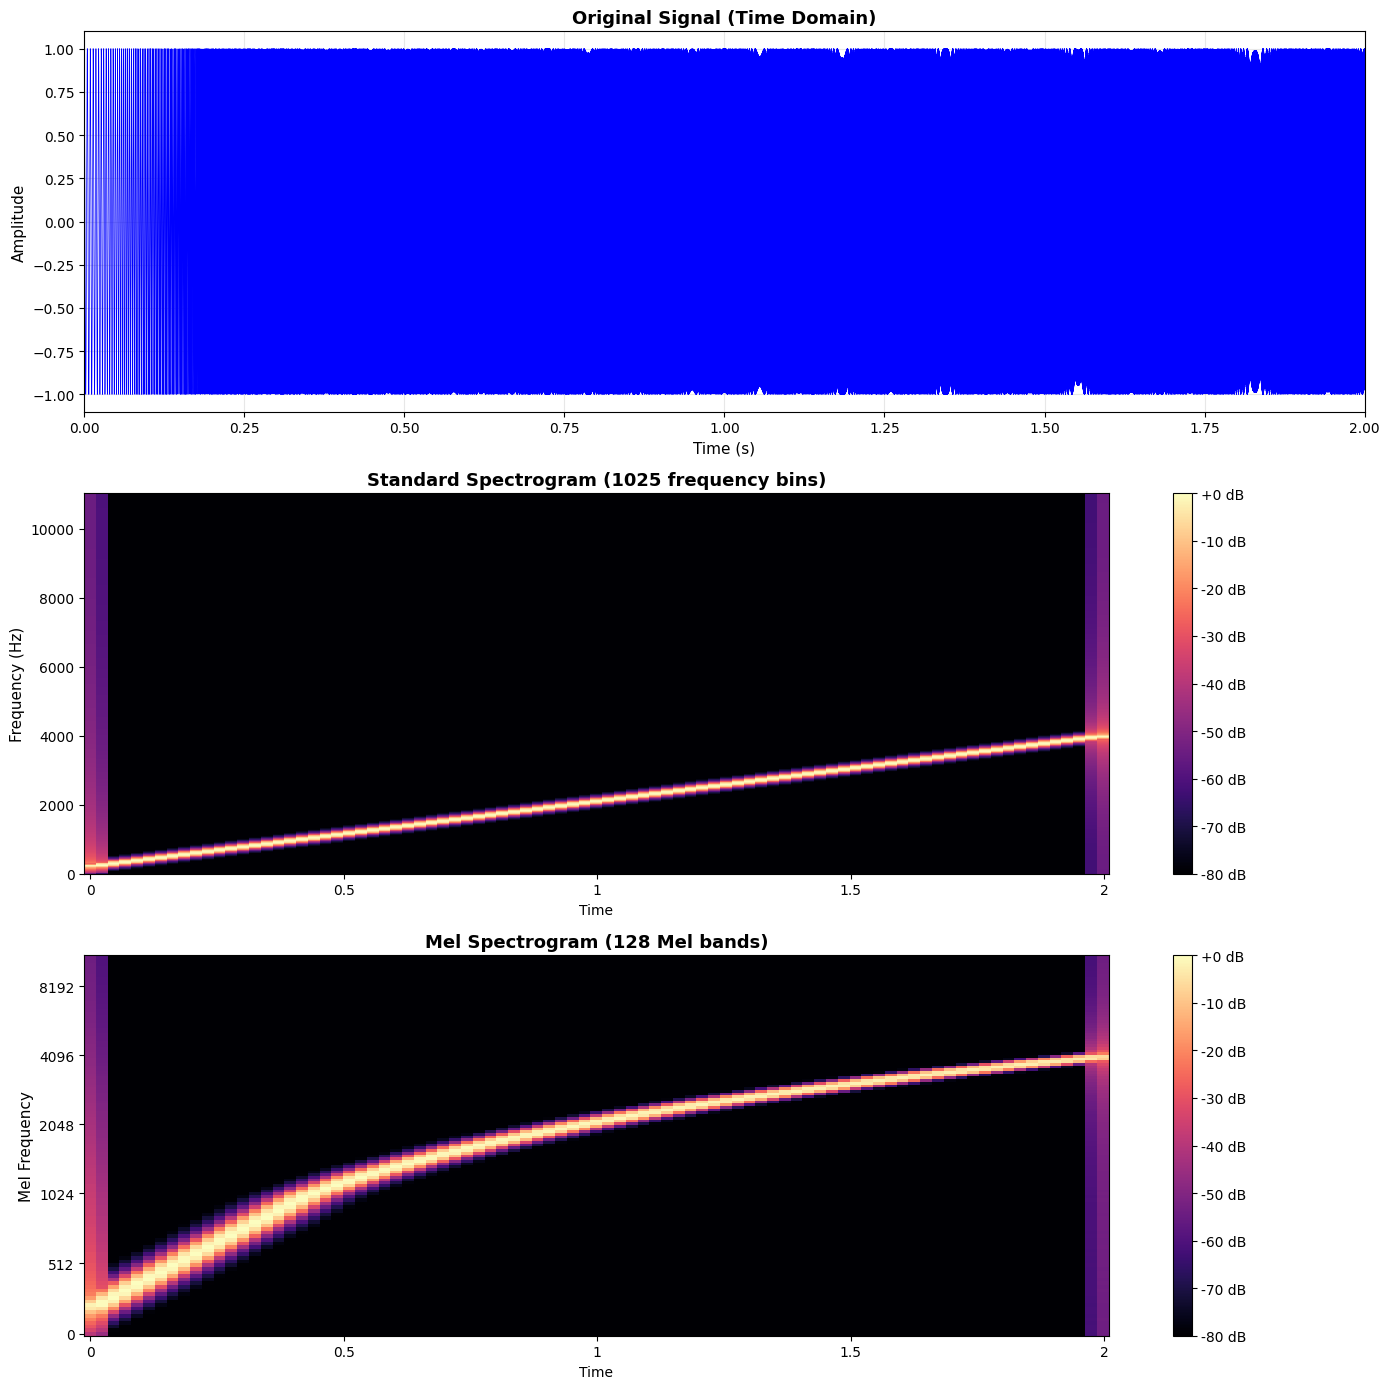


📊 Visual Comparison:
  MIDDLE (Standard): Linear frequency scale, equal spacing
  BOTTOM (Mel): Perceptual frequency scale, more detail at low frequencies

💡 Notice: Mel spectrogram emphasizes low-frequency details!


In [11]:
# Visualize the transformation
fig, axes = plt.subplots(3, 1, figsize=(14, 14))

# Plot 1: Original waveform
axes[0].plot(t, test_signal, 'b-', linewidth=0.5)
axes[0].set_xlabel('Time (s)', fontsize=11)
axes[0].set_ylabel('Amplitude', fontsize=11)
axes[0].set_title('Original Signal (Time Domain)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, duration])

# Plot 2: Standard Spectrogram
img1 = librosa.display.specshow(D_db, sr=sr, hop_length=hop_length,
                                x_axis='time', y_axis='hz', cmap='magma', ax=axes[1])
axes[1].set_title(f'Standard Spectrogram ({D_power.shape[0]} frequency bins)', 
                 fontsize=13, fontweight='bold')
axes[1].set_ylabel('Frequency (Hz)', fontsize=11)
plt.colorbar(img1, ax=axes[1], format='%+2.0f dB')

# Plot 3: Mel Spectrogram
img2 = librosa.display.specshow(mel_spec_db, sr=sr, hop_length=hop_length,
                                x_axis='time', y_axis='mel', cmap='magma', ax=axes[2])
axes[2].set_title(f'Mel Spectrogram ({mel_spec.shape[0]} Mel bands)', 
                 fontsize=13, fontweight='bold')
axes[2].set_ylabel('Mel Frequency', fontsize=11)
plt.colorbar(img2, ax=axes[2], format='%+2.0f dB')

plt.tight_layout()
plt.show()

print("\n📊 Visual Comparison:")
print("  MIDDLE (Standard): Linear frequency scale, equal spacing")
print("  BOTTOM (Mel): Perceptual frequency scale, more detail at low frequencies")
print("\n💡 Notice: Mel spectrogram emphasizes low-frequency details!")

---

# Part 5: Mel vs Standard - Complete Comparison

## Key Differences Summary

| Aspect | Standard Spectrogram | Mel Spectrogram |
|--------|---------------------|------------------|
| **Frequency Scale** | Linear (Hz) | Logarithmic (Mel) |
| **Frequency Bins** | 1025 (n_fft/2+1) | 128 (n_mels) |
| **Resolution** | Equal everywhere | Variable (fine→coarse) |
| **Low Frequencies** | Less detail | More detail |
| **High Frequencies** | More detail | Less detail |
| **Perceptual** | No | Yes |
| **Data Size** | Larger | Smaller (compressed) |
| **Best For** | Frequency analysis | ML/AI, Speech, Music |

## When to Use Each

### Use Standard Spectrogram:
- ✅ Precise frequency analysis
- ✅ Pitch detection
- ✅ Harmonic analysis
- ✅ Scientific measurements

### Use Mel Spectrogram:
- ✅ Speech recognition
- ✅ Music genre classification
- ✅ Audio event detection
- ✅ Deep learning models
- ✅ Perceptual audio coding

---

# Part 6: Practical Implementation

## Using Librosa (Recommended)

In [12]:
# Standard way to compute Mel spectrogram
def compute_mel_spectrogram(audio, sr, n_fft=2048, hop_length=512, n_mels=128):
    """
    Compute Mel spectrogram using librosa
    
    Parameters:
    -----------
    audio : ndarray
        Audio time series
    sr : int
        Sampling rate
    n_fft : int
        FFT window size
    hop_length : int
        Number of samples between frames
    n_mels : int
        Number of Mel bands
    
    Returns:
    --------
    mel_spec_db : ndarray
        Mel spectrogram in dB scale
    """
    # Compute Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    
    # Convert to dB scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    return mel_spec_db

# Example usage
mel_spec_example = compute_mel_spectrogram(test_signal, sr)
print(f"Mel Spectrogram shape: {mel_spec_example.shape}")
print(f"Value range: [{mel_spec_example.min():.2f}, {mel_spec_example.max():.2f}] dB")

Mel Spectrogram shape: (128, 87)
Value range: [-80.00, 0.00] dB


### Effect of n_mels Parameter

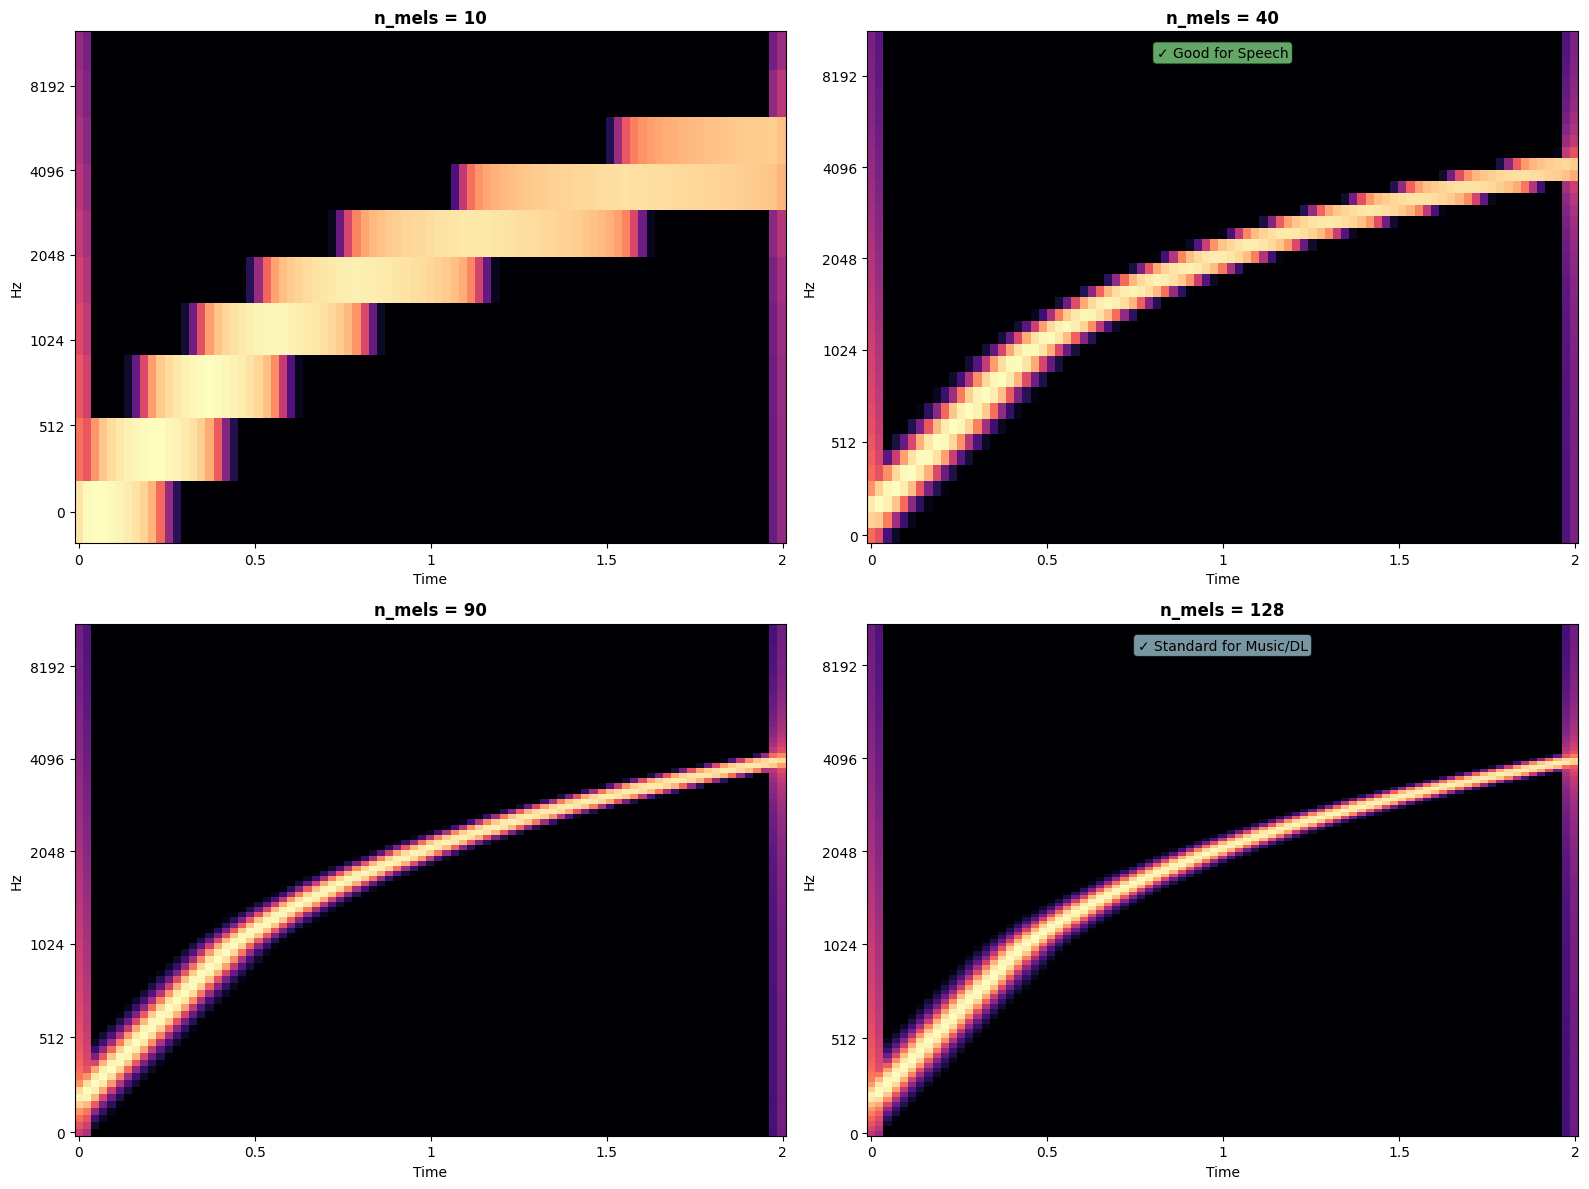


📊 Recommendations:
  - n_mels = 10: Too coarse, not recommended
  - n_mels = 40: Good for speech recognition
  - n_mels = 90: Good balance
  - n_mels = 128: Standard for music and deep learning


In [13]:
# Compare different n_mels values
n_mels_values = [10, 40, 90, 128]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, n_mels_val in enumerate(n_mels_values):
    mel_temp = librosa.feature.melspectrogram(
        y=test_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels_val
    )
    mel_temp_db = librosa.power_to_db(mel_temp, ref=np.max)
    
    librosa.display.specshow(mel_temp_db, sr=sr, hop_length=hop_length,
                             x_axis='time', y_axis='mel', cmap='magma', ax=axes[idx])
    axes[idx].set_title(f'n_mels = {n_mels_val}', fontsize=12, fontweight='bold')
    
    # Add recommendation
    if n_mels_val == 40:
        axes[idx].text(0.5, 0.95, '✓ Good for Speech',
                      transform=axes[idx].transAxes, ha='center',
                      bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    elif n_mels_val == 128:
        axes[idx].text(0.5, 0.95, '✓ Standard for Music/DL',
                      transform=axes[idx].transAxes, ha='center',
                      bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n📊 Recommendations:")
print("  - n_mels = 10: Too coarse, not recommended")
print("  - n_mels = 40: Good for speech recognition")
print("  - n_mels = 90: Good balance")
print("  - n_mels = 128: Standard for music and deep learning")

---

# Summary

## Key Takeaways

### 1. The Problem
- Humans hear logarithmically, not linearly
- Standard spectrograms don't match human perception
- Need perceptual frequency scale

### 2. The Mel Scale
- **Formula**: `m = 2595 * log10(1 + f/700)`
- Approximately logarithmic above 1000 Hz
- Equal Mel distances = equal perceived pitch differences

### 3. Mel Filter Banks
- Triangular filters spaced on Mel scale
- Narrow at low frequencies (detailed)
- Wide at high frequencies (coarse)
- 50% overlap for smooth coverage

### 4. Mel Spectrograms
- Matrix multiplication: FilterBank × Spectrogram
- Compresses 1025 bins → 128 bands
- Preserves perceptually important information
- Standard input for audio deep learning

### 5. Practical Use
- **Speech**: n_mels = 40-80
- **Music**: n_mels = 128
- **Standard params**: n_fft=2048, hop_length=512

## The Big Picture

```
Audio Signal
    ↓
STFT (FFT Parameters from Notebook 11)
    ↓
Standard Spectrogram (1025 bins, linear)
    ↓
Mel Filter Bank (128 filters, logarithmic)
    ↓
Mel Spectrogram (128 bands, perceptual)
    ↓
Deep Learning Model
```

---

**You now understand Mel Spectrograms completely!** 🎉

This is the foundation for:
- MFCCs (Mel-Frequency Cepstral Coefficients)
- Audio classification
- Speech recognition
- Music information retrieval